In [1]:
from torch.utils.data import Dataset
import torch
import numpy as np
import json
import cv2

def resample_contour(contour, n_points=128):
    contour = contour[:, 0, :]
    if not np.array_equal(contour[0], contour[-1]):
        contour = np.vstack([contour, contour[0]])
    deltas = np.diff(contour, axis=0)
    dists = np.sqrt((deltas ** 2).sum(axis=1))
    dist_cum = np.insert(np.cumsum(dists), 0, 0)
    uniform_dist = np.linspace(0, dist_cum[-1], n_points)
    x_new = np.interp(uniform_dist, dist_cum, contour[:, 0])
    y_new = np.interp(uniform_dist, dist_cum, contour[:, 1])
    contour_resampled = np.stack([x_new, y_new], axis=1).astype(np.float32)
    return contour_resampled

class ContourDataset(Dataset):
    def __init__(self, json_path, n_points=128, width=512, height=512):
        self.contours = []
        with open(json_path, 'r') as f:
            data = json.load(f)
        for contours in data.values():
            for c in contours.values():
                x = np.array(c['x'])
                y = np.array(c['y'])
                pts = np.vstack((x, y)).T.astype(np.int32).reshape(-1, 1, 2)
                resampled = resample_contour(pts, n_points=n_points)
                normed = resampled / np.array([width, height])
                normed[-1] = normed[0]  # Força fechamento
                self.contours.append(normed)
    
    def __len__(self):
        return len(self.contours)
    
    def __getitem__(self, idx):
        return torch.tensor(self.contours[idx], dtype=torch.float32)


In [2]:
import torch.nn as nn

class SeqGeneratorGRU(nn.Module):
    def __init__(self, z_dim=100, hidden_dim=128, seq_len=128):
        super().__init__()
        self.seq_len = seq_len
        self.hidden = nn.Linear(z_dim, hidden_dim)
        self.gru = nn.GRU(input_size=2, hidden_size=hidden_dim, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim, 2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):
        batch_size = z.size(0)
        h = torch.tanh(self.hidden(z)).unsqueeze(0)  # (1, batch, hidden)
        start = torch.zeros(batch_size, 1, 2).to(z.device)
        outputs = [start]
        for _ in range(self.seq_len - 1):
            out, h = self.gru(outputs[-1], h)
            next_point = self.sigmoid(self.fc_out(out))  # (batch, 1, 2)
            outputs.append(next_point)
        seq = torch.cat(outputs, dim=1)
        seq[:, -1, :] = seq[:, 0, :]  # força fechamento
        return seq


In [3]:
class SeqDiscriminator(nn.Module):
    def __init__(self, seq_len=128):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(seq_len * 2, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    
    def forward(self, seq):
        return self.model(seq)


In [4]:
def closure_loss(seq):
    return torch.mean((seq[:, 0, :] - seq[:, -1, :]) ** 2)

def smoothness_loss(seq):
    return torch.mean((seq[:, 2:, :] - 2*seq[:, 1:-1, :] + seq[:, :-2, :]) ** 2)


In [5]:
from torch.utils.data import DataLoader
import torch.optim as optim

def train_gan(json_path, epochs=100, batch_size=32, z_dim=100, device='cuda'):
    dataset = ContourDataset(json_path)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    generator = SeqGeneratorGRU(z_dim=z_dim).to(device)
    discriminator = SeqDiscriminator().to(device)

    optim_G = optim.Adam(generator.parameters(), lr=2e-4)
    optim_D = optim.Adam(discriminator.parameters(), lr=2e-4)

    bce = nn.BCELoss()

    for epoch in range(epochs):
        for real_batch in dataloader:
            real_batch = real_batch.to(device)

            # Train discriminator
            z = torch.randn(real_batch.size(0), z_dim).to(device)
            fake_batch = generator(z).detach()
            d_real = discriminator(real_batch)
            d_fake = discriminator(fake_batch)

            real_labels = torch.ones_like(d_real)
            fake_labels = torch.zeros_like(d_fake)

            loss_d = bce(d_real, real_labels) + bce(d_fake, fake_labels)
            optim_D.zero_grad()
            loss_d.backward()
            optim_D.step()

            # Train generator
            z = torch.randn(real_batch.size(0), z_dim).to(device)
            fake_batch = generator(z)
            d_fake = discriminator(fake_batch)

            adv_loss = bce(d_fake, real_labels)
            close = closure_loss(fake_batch)
            smooth = smoothness_loss(fake_batch)

            loss_g = adv_loss + 10 * close + 1 * smooth
            optim_G.zero_grad()
            loss_g.backward()
            optim_G.step()

        print(f"[{epoch+1}/{epochs}] Loss_D: {loss_d.item():.4f} | Loss_G: {loss_g.item():.4f} (closure: {close.item():.4f}, smooth: {smooth.item():.4f})")

    return generator


Iniciando treinamento da GAN...
[1/50] Loss_D: 0.1579 | Loss_G: 2.0201 (closure: 0.0000, smooth: 0.0027)
[2/50] Loss_D: 0.0039 | Loss_G: 5.9131 (closure: 0.0000, smooth: 0.0103)
[3/50] Loss_D: 0.0040 | Loss_G: 5.5733 (closure: 0.0000, smooth: 0.0312)
[4/50] Loss_D: 0.0032 | Loss_G: 6.5562 (closure: 0.0000, smooth: 0.0057)
[5/50] Loss_D: 0.0566 | Loss_G: 6.5543 (closure: 0.0000, smooth: 0.0044)
[6/50] Loss_D: 0.0006 | Loss_G: 7.5617 (closure: 0.0000, smooth: 0.0072)
[7/50] Loss_D: 0.0008 | Loss_G: 7.1455 (closure: 0.0000, smooth: 0.0087)
[8/50] Loss_D: 0.0013 | Loss_G: 6.7592 (closure: 0.0000, smooth: 0.0020)
[9/50] Loss_D: 0.0003 | Loss_G: 8.1660 (closure: 0.0000, smooth: 0.0064)
[10/50] Loss_D: 0.0003 | Loss_G: 8.0076 (closure: 0.0000, smooth: 0.0079)
[11/50] Loss_D: 0.0012 | Loss_G: 6.7708 (closure: 0.0000, smooth: 0.0088)
[12/50] Loss_D: 0.0032 | Loss_G: 5.7836 (closure: 0.0000, smooth: 0.0148)
[13/50] Loss_D: 0.0007 | Loss_G: 7.2577 (closure: 0.0000, smooth: 0.0041)
[14/50] Loss_D:

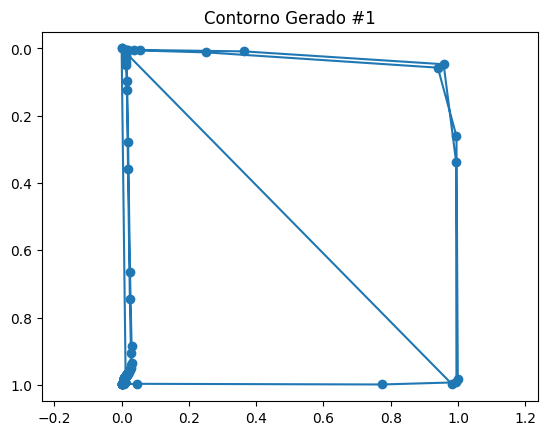

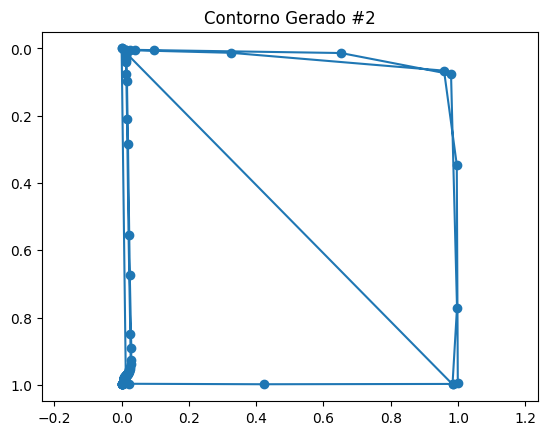

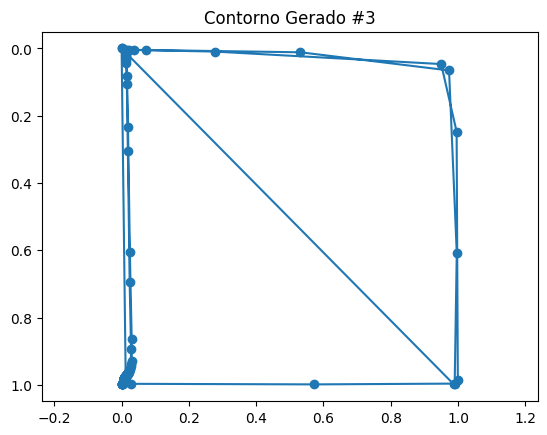

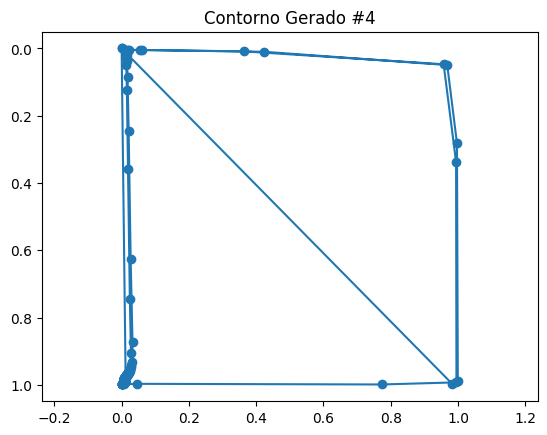

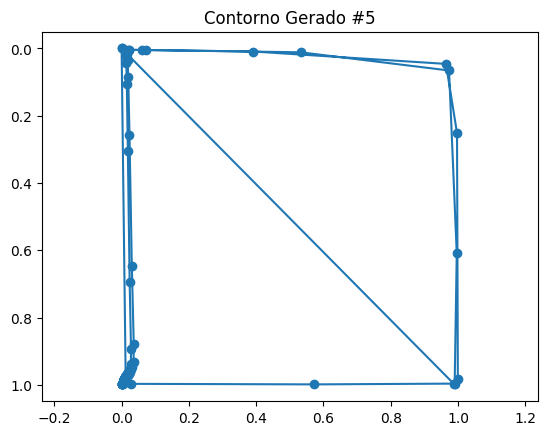

In [6]:
if __name__ == "__main__":
    import os

    # Configurações
    JSON_PATH = "dataset_contours_aggregate.json"  # caminho para seu dataset JSON
    Z_DIM = 100
    EPOCHS = 50
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

    # Treinamento da GAN
    print("Iniciando treinamento da GAN...")
    generator = train_gan(
        json_path=JSON_PATH,
        epochs=EPOCHS,
        batch_size=32,
        z_dim=Z_DIM,
        device=DEVICE
    )

    # Salvar modelo (opcional)
    torch.save(generator.state_dict(), "generator_trained.pth")
    print("Modelo salvo como 'generator_trained.pth'")

    # Gerar e visualizar contornos sintéticos
    print("Gerando contornos sintéticos...")
    generator.eval()
    z = torch.randn(5, Z_DIM).to(DEVICE)
    with torch.no_grad():
        fake_seqs = generator(z).cpu().numpy()  # shape (5, seq_len, 2)

    import matplotlib.pyplot as plt

    for i, contour in enumerate(fake_seqs):
        plt.plot(contour[:, 0], contour[:, 1], marker='o')
        plt.title(f"Contorno Gerado #{i+1}")
        plt.gca().invert_yaxis()
        plt.axis('equal')
        plt.show()
